# Supervariant

In [256]:
import pandas as pd
import numpy as np
import Levenshtein
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
from sciutil import SciUtil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import AlignIO
import numpy as np
import re
import pandas as pd
# get all the sequnence function files and see what those specific mutations did
# Also did any of the other mutations appear in the H2NOH files
import os
from copy import deepcopy
# Get them w.r.t to a mutation
from scipy.stats import mannwhitneyu
# get all the sequnence function files and see what those specific mutations did
# Also did any of the other mutations appear in the H2NOH files
import os
import numpy as np
from tqdm import tqdm
from sciutil import SciUtil


u = SciUtil()

# Helper functions
# Sort rows by similarity (Hamming distance) to first row
def hamming_distance(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum(a != b for a, b in zip(seq1, seq2))
    
def get_hamming(df, parent_name, variant_name):
    parent = df[df['name'] == parent_name]['AA'].values[0]
    variant = df[df['name'] == variant_name]['AA'].values[0]
    # Since the same we can do hamming distance
    hamming_dist = 0
    variant_changes = []
    for i in range(0, len(parent)):
        if parent[i] != variant[i]:
            variant_changes.append(f'{parent[i]}{i+1}{variant[i]}')
            hamming_dist += 1
    u.dp([f'Hamming distance between {parent_name} and {variant_name}', hamming_dist, '_'.join(variant_changes)])
    return variant_changes

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=90)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax


plt.rcParams['svg.fonttype'] = 'none'

output_dir = 'output/'
fig_dir = 'figs/'

lineage_df = pd.read_csv('lineage_summary.tsv', sep='\t')
lineage_df['name'] = [f'{l}_{n}' for l, n in lineage_df[['linage', 'name']].values]
lineage_df.dropna()
# Keep track of the parents for the LevSeq data
lineage_df['AA'] = [d.replace('*', '') for d in lineage_df['AA'].values]
parent_to_name = dict(zip(lineage_df.AA, lineage_df.name))
parents = list(lineage_df.AA.values)

# Amino acid code conversion
AA_DICT = {
    "Ala": "A",
    "Cys": "C",
    "Asp": "D",
    "Glu": "E",
    "Phe": "F",
    "Gly": "G",
    "His": "H",
    "Ile": "I",
    "Lys": "K",
    "Leu": "L",
    "Met": "M",
    "Asn": "N",
    "Pro": "P",
    "Gln": "Q",
    "Arg": "R",
    "Ser": "S",
    "Thr": "T",
    "Val": "V",
    "Trp": "W",
    "Tyr": "Y",
    "Ter": "*",
}


def normalise_calculate_stats(processed_plate_df, value_column, normalise="standard", stats_method="mannwhitneyu", parent_label="#PARENT#", normalise_method="median", parent_to_name = None):
    # if nomrliase normalize with standard normalisation
    normalised_df = pd.DataFrame()
    all_stats_df = pd.DataFrame()
    processed_plate_df[value_column] = pd.to_numeric(processed_plate_df[value_column], errors='coerce')

    for plate in set(processed_plate_df["barcode_plate"].values):
        # Normalize for each value
        plate_parent = None
        plate_campaign = None
        sub_df = processed_plate_df[processed_plate_df["barcode_plate"] == plate].copy()
        parent_values = sub_df[sub_df["amino_acid_substitutions"] == parent_label][value_column].values
        if len(parent_values) == 0:
            u.err_p(['No parent!!! skipping plate... ', plate])
            continue
        else:
            plate_parent = sub_df[sub_df["amino_acid_substitutions"] == parent_label]['aa_sequence'].values[0]
            # By default use the median
            if normalise_method == "median":
                parent_mean = np.nanmedian(parent_values)
            else:
                parent_mean = np.nanmean(parent_values)
            parent_sd = np.nanstd(parent_values)
    
            # For each plate we normalise to the parent of that plate
            sub_df[f"{value_column} plate standard norm"] = (sub_df[value_column].values - parent_mean) / parent_sd
            sub_df[f"{value_column} fold change"] = sub_df[value_column].values/ parent_mean
            sub_df[f"{value_column} parent {normalise_method}"] = parent_mean
            sub_df[f"{value_column} parent SD"] = parent_sd

            norm_value_column = f"{value_column} plate standard norm"    
            sd_cutoff = 1.5  # The number of standard deviations we want above the parent values
            # Now for all the other mutations we want to look if they are significant, first we'll look at combinations and then individually
            grouped_by_mutations = sub_df.groupby("amino_acid_substitutions")
        
            rows = []
            for mutation, grp in grouped_by_mutations:
                # Get the values and then do a ranksum test
                if mutation != parent_label:
                    vals = list(grp[norm_value_column].values)
                    U1, p = None, None
                    # Now check if there are 3 otherwise we just do > X S.D over - won't be sig anyway.
                    if len(grp) > 2:
                        # Do stats
                        U1, p = mannwhitneyu(parent_values, vals, method="exact")
                    if normalise_method == "median":
                        mean_vals = np.nanmedian(vals)
                    else:
                        mean_vals = np.nanmean(vals)
                    std_vals = np.nanstd(vals)
                    median_vals = np.nanmedian(vals)
                    sig = mean_vals > ((sd_cutoff * parent_sd) + parent_mean)
                    rows.append([value_column, mutation, len(grp), mean_vals, std_vals, median_vals, (mean_vals - parent_mean)/parent_sd, sig, U1, p, plate_campaign, plate_parent, plate])
            stats_df = pd.DataFrame(rows, columns=["value_column",  "amino_acid_substitutions", "number of wells with amino_acid substitutions", "mean",
                    "std", "median", "standard normalized to parent mean", f"greater than > {sd_cutoff} parent", "man whitney U stat",
                    "p-value", 'campaign',  'parent', 'plate'],
                )
            all_stats_df = pd.concat([all_stats_df, stats_df])
            normalised_df = pd.concat([normalised_df, sub_df])

    return all_stats_df, normalised_df


def get_dist(seq1, seq2):
    seq1 = list(seq1)
    seq2 = list(seq2)
    dist = 0
    if len(seq1) != len(seq2):
        print(len(seq1), len(seq2), 'YIKES')
    for i in range(0, len(seq1)):
        if seq1[i] != seq2[i]:
            dist += 1
    #print(dist/len(seq1))
    return dist/len(seq1)



In [224]:
import os

u = SciUtil()

all_dfs = {}
all_stats_dfs = pd.DataFrame()
all_df = pd.DataFrame()

summary_rows = []
for base_dir in ['LCMS/H2NOH-linage_Done']:
    files = [f for f in os.listdir(base_dir) if '.csv' in f]
    for f in files:
        if f == '250714_HA-G7_step.csv':
            # Get all the sequence function files.
            run_name = f.replace('.csv', '')
            if os.path.exists(os.path.join(base_dir, run_name)):
                function_files = os.listdir(os.path.join(base_dir, run_name))
                
                all_function_df = pd.DataFrame()
                for function_file in function_files:
                    #try:
                    # Barcode
                    barcode = function_file.split('.csv')[0].split('_')[-1]
                    function_df = pd.read_csv(f'{base_dir}/{run_name}/{function_file}')
                    # Now we want to line up the barcode with the file and then join on the wells
                    function_df['function_well'] = [x.split('-')[-1] if isinstance(x, str) else None for x in function_df['Sample Vial Number'].values]
                    function_df['function_barcode_plate'] = barcode
                    u.dp([f, set(function_df['Compound Name'].values)])
                    function_df = function_df[function_df['Compound Name'].isin(['Pdt', 'pdt'])] # We only use pdt or Pdt
                    # Convert it to numeric 
                    function_df['Area'] = pd.to_numeric(function_df['Area'], errors='coerce')

                    function_df['barcode_well'] = [f'{p}_{w}' for w, p in function_df[['function_well', 'function_barcode_plate']].values]
                    function_df['filename'] = function_file
                    all_function_df = pd.concat([all_function_df, function_df])
                    # except:
                    #     print('fuction file', function_file)
                df = pd.read_csv(f'{base_dir}/{f}')
                
                df.columns = [c.lower() for c in df.columns]
                if 'barcode_plate' not in df.columns:
                    df = df.rename(columns={'protein sequence': 'aa_sequence'})
                    df['barcode_plate'] = df['plate'].values
    
                df['barcode_well'] = [f'{p}_{w}' for w, p in df[['well', 'barcode_plate']].values]
                # Join the two
                df.set_index('barcode_well', inplace=True)
                all_function_df.set_index('barcode_well', inplace=True)
                df = df.join(all_function_df, how='left')
                df.reset_index(inplace=True, drop=True)
                df['levSeq_filename'] = run_name
                df.columns = [c.replace(' ', '_') for c in df.columns]
                df = df[['barcode_plate',
                         'plate',
                         'nucleotide_mutation',
                         'amino_acid_substitutions',
                         'well', 
                         'average_mutation_frequency', 
                         'alignment_count',
                         'aa_sequence',
                         'Sample_Acq_Order_No', 'Sample_Vial_Number', 'Sample_Name',
                         'Compound_Name', 'RT_[min]', 'Area', 'function_well',
                         'function_barcode_plate', 'filename', 'levSeq_filename']]
                df = df.loc[:,~df.columns.duplicated()].copy()
                # Need to add in the fitness and the fitness_value	smiles_string
                df['fitness_value'] = df['Area'].values
                df['smiles_string'] = 'O=C(OC)C[C@H](N)C1=CC=CC=C1'
                # Get which parent it is
                min_dist = 1000
                generation_name = None
                # Will throw an error if there is no parent (but this is good because we don't want this then!)
                aa = df[df['amino_acid_substitutions'] == '#PARENT#']['aa_sequence'].values[0].replace('*', '')
                aa = aa.replace('*', '')
                # For the parent get the distance - some might have 1 or 2 aa's different... i.e. in stop codon
                for p in parents:
                    parent_dist = get_dist(p, aa)
                    if parent_dist < min_dist:
                        min_dist = parent_dist
                        generation_name = parent_to_name.get(p)
                        
                df['campaign_name'] = generation_name
                all_dfs[run_name] = df
    
                df = df.drop_duplicates(subset=['barcode_plate', 'well'])
                df = df.dropna(subset='Area')
                df = df.fillna(0)
                df.to_csv(f'{output_dir}/seqfunc/{generation_name}_{f}')
                stats_df, df = normalise_calculate_stats(df, 'Area',
                                normalise="standard",
                                stats_method="mannwhitneyu",
                                parent_label="#PARENT#",
                                normalise_method="mean",
                                parent_to_name = parent_to_name)
                stats_df['levSeq_filename'] = run_name
                all_df = pd.concat([all_df, df])
                all_stats_dfs =  pd.concat([all_stats_dfs, stats_df])
                u.warn_p(['Success!', run_name, generation_name, 'Distance between parent and generation:', min_dist, 
                         '\n # non zero fitness: ', len(df[df['fitness_value'] != 0]), '\n Size of dataset: ', len(df), 
                         '\n # unique sustitutions: ', len(set(df['amino_acid_substitutions'].values))])
    
                summary_rows.append([run_name, generation_name, min_dist, len(df[df['fitness_value'] != 0]), len(df), len(set(df['amino_acid_substitutions'].values))])

all_df



--------------------------------------------------------------------------------
                         250714_HA-G7_step.csv	{'Pdt'}	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         250714_HA-G7_step.csv	{'Pdt'}	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         250714_HA-G7_step.csv	{'Pdt'}	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         250714_HA-G7_step.csv	{'Pdt'}	                         
--------------------------------------------------------------------------------
----------------------------

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193265282.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_df = pd.concat([all_stats_df, stats_df])
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193265282.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_df = pd.concat([all_stats_df, stats_df])


,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD
480,26,HA-G7_step_1,#PARENT#,#LOW#,A1,0.000000,9.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,2.0,D3F-A1,...,26,250714_HA-G7_step_26.csv,250714_HA-G7_step,3642.2626,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-2.348801,0.024507,148621.293433,61724.706091
481,26,HA-G7_step_1,#PARENT#,#PARENT#,A2,0.000000,534.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,3.0,D3F-A2,...,26,250714_HA-G7_step_26.csv,250714_HA-G7_step,221900.9717,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,1.187202,1.493063,148621.293433,61724.706091
482,26,HA-G7_step_1,A298T_T300G,T100S,A3,0.872277,505.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,4.0,D3F-A3,...,26,250714_HA-G7_step_26.csv,250714_HA-G7_step,133913.2384,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-0.238285,0.901037,148621.293433,61724.706091
483,26,HA-G7_step_1,#PARENT#,#PARENT#,A4,0.000000,26.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,5.0,D3F-A4,...,26,250714_HA-G7_step_26.csv,250714_HA-G7_step,1476.5688,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-2.383887,0.009935,148621.293433,61724.706091
484,26,HA-G7_step_1,A29G_T30C,D10G,A5,0.906869,757.0,MAPSDIPGYGYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,6.0,D3F-A5,...,26,250714_HA-G7_step_26.csv,250714_HA-G7_step,135151.3355,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-0.218226,0.909367,148621.293433,61724.706091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,31,HA-G7_step_6,T277C_G278T,W93L,H7,0.833333,36.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,74.0,D5B-H7,...,31,250714_HA-G7_step_31.csv,250714_HA-G7_step,2080.6096,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-3.331999,0.009853,211166.789194,62750.972271
92,31,HA-G7_step_6,#PARENT#,#PARENT#,H9,0.000000,56.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,75.0,D5B-H9,...,31,250714_HA-G7_step_31.csv,250714_HA-G7_step,233143.1235,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,0.350215,1.104071,211166.789194,62750.972271
93,31,HA-G7_step_6,T277C_G278T,W93L,H10,0.890000,100.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,76.0,D5B-H10,...,31,250714_HA-G7_step_31.csv,250714_HA-G7_step,2975.2963,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-3.317741,0.014090,211166.789194,62750.972271
94,31,HA-G7_step_6,T277C_G278T,W93L,H11,0.824561,57.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,77.0,D5B-H11,...,31,250714_HA-G7_step_31.csv,250714_HA-G7_step,1597.1053,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-3.339704,0.007563,211166.789194,62750.972271


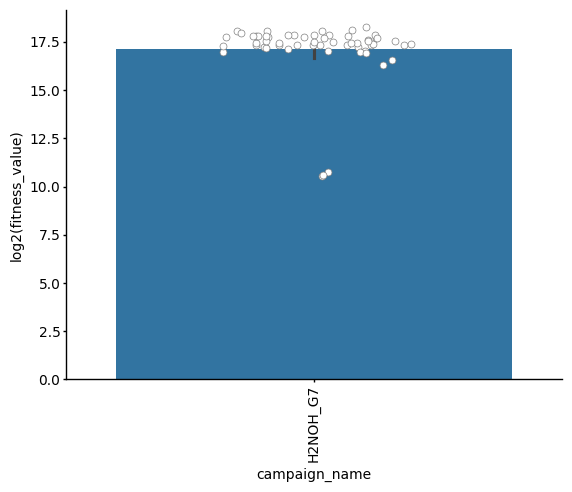

In [225]:
plate_df = all_df[all_df['amino_acid_substitutions'] == '#PARENT#']
plate_df = plate_df.reset_index()
plate_df['log2(fitness_value)'] = np.log2(plate_df['fitness_value'].values + 1)
ax = sns.barplot(plate_df, x='campaign_name', y='log2(fitness_value)')
ax = sns.stripplot(plate_df, x='campaign_name', y='log2(fitness_value)', ax=ax, jitter=0.2, c='white', edgecolor='grey', linewidth=0.5)

ax = clean_plt(ax)

In [226]:
all_df.sort_values(by='Area fold change', ascending=False)

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD
491,26,HA-G7_step_1,A127C_A128G_G129T_G573T,K43R_K191N,A12,0.879687,160.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKRAAD...,11.0,D3F-A12,...,26,250714_HA-G7_step_26.csv,250714_HA-G7_step,268706.9378,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,1.945504,1.807998,148621.293433,61724.706091
376,28,HA-G7_step_3,#PARENT#,#LOW#,H5,0.000000,4.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,35.0,D4F-H5,...,28,250714_HA-G7_step_28.csv,250714_HA-G7_step,348049.2842,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,3.037536,1.759125,197853.680033,49446.525566
514,26,HA-G7_step_1,A127C_A128G_G129T,K43R,C11,0.894126,891.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKRAAD...,28.0,D3F-C11,...,26,250714_HA-G7_step_26.csv,250714_HA-G7_step,252066.0988,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,1.675906,1.696030,148621.293433,61724.706091
502,26,HA-G7_step_1,G112A_A114T_G573T,V38I_K191N,B11,0.885154,595.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDIMYLKKAAD...,20.0,D3F-B11,...,26,250714_HA-G7_step_26.csv,250714_HA-G7_step,246826.7222,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,1.591023,1.660776,148621.293433,61724.706091
476,27,HA-G7_step_2,#PARENT#,#PARENT#,H9,0.000000,176.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,63.0,D3B-H9,...,27,250714_HA-G7_step_27.csv,250714_HA-G7_step,310965.0001,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,2.293199,1.620767,191862.887763,51937.104098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,30,HA-G7_step_5,#PARENT#,#LOW#,A1,0.000000,4.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,2.0,D5F-A1,...,30,250714_HA-G7_step_30.csv,250714_HA-G7_step,1418.2612,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-6.771841,0.007794,181977.000700,26663.168076
94,31,HA-G7_step_6,T277C_G278T,W93L,H11,0.824561,57.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,77.0,D5B-H11,...,31,250714_HA-G7_step_31.csv,250714_HA-G7_step,1597.1053,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-3.339704,0.007563,211166.789194,62750.972271
44,31,HA-G7_step_6,#PARENT#,#PARENT#,D9,0.000000,18.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,46.0,D5B-D9,...,31,250714_HA-G7_step_31.csv,250714_HA-G7_step,1528.3078,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-3.340801,0.007237,211166.789194,62750.972271
462,27,HA-G7_step_2,G43DEL_G45T_T80G_G81A_G87C_G123INS_G123G_G177D...,#LOW#,G7,0.862069,1.0,#DEL#,54.0,D3B-G7,...,27,250714_HA-G7_step_27.csv,250714_HA-G7_step,1352.9692,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G7,-3.668089,0.007052,191862.887763,51937.104098


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/1276768112.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)',
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/1276768112.py:8: UserWarning: 
The palette list has fewer values (1) than needed (67) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)',


Text(0.5, 1.0, 'Log2(fitness value)')

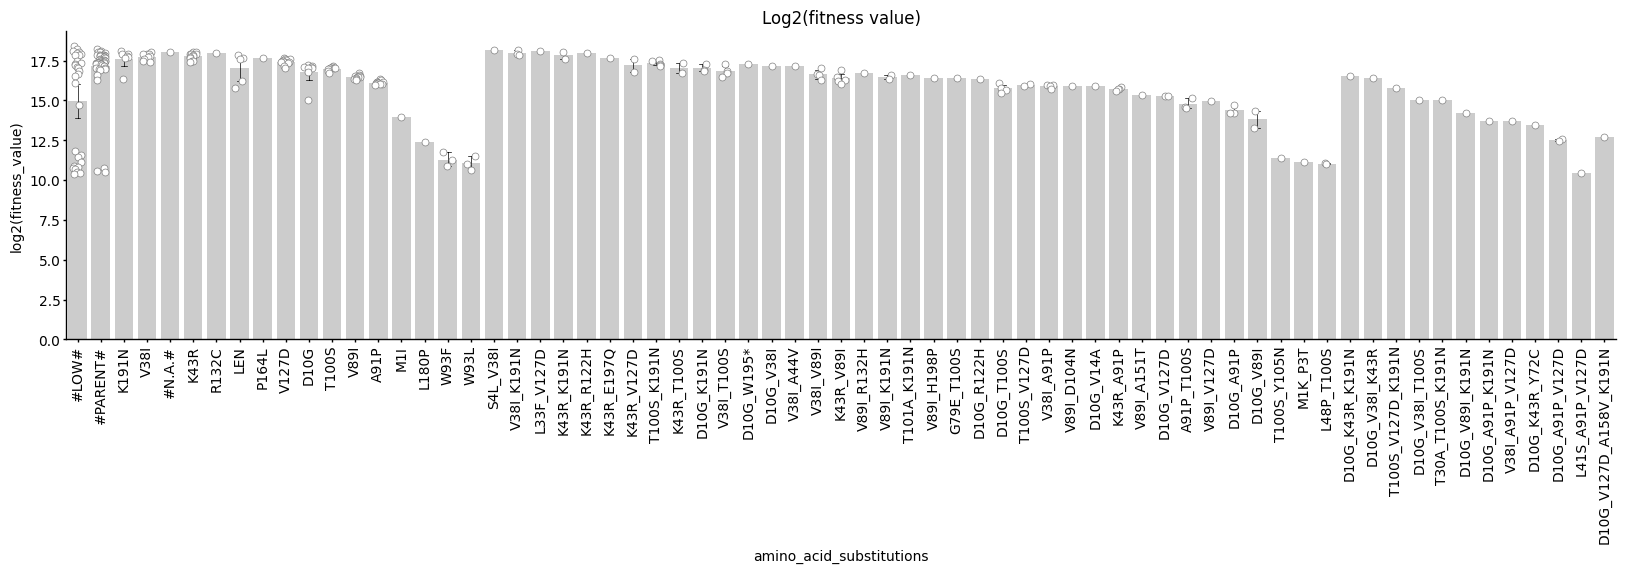

In [227]:
plt.figure(figsize=(20, 4))
plate_df = all_df.copy()# all_df[all_df['amino_acid_substitutions'] == '#PARENT#']
plate_df = plate_df.reset_index()
plate_df['log2(fitness_value)'] = np.log2(plate_df['fitness_value'].values + 1)
plate_df['num_muts'] = [len(m.split('_')) for m in plate_df['amino_acid_substitutions'].values]

plate_df = plate_df.sort_values(by=['num_muts', 'log2(fitness_value)'], ascending=[True, False])
ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', 
                   err_kws={"color": 'black', "linewidth": 0.5},
                     capsize=.25, palette=['#cccc'],legend=False)
ax = sns.stripplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', ax=ax, jitter=0.2, c='white', edgecolor='grey', linewidth=0.5)
ax = clean_plt(ax)
plt.title('Log2(fitness value)')


# Filter to remove variants we didn't want to make the figures nicer

In [229]:
from sciutil import SciUtil

u = SciUtil()

# get the number of times that each position can occur with another one in a series
from itertools import combinations
L = ['10G', '38I', '91P', '191N', '100S', '89I', '43R', '127D']
# 191 38 43 | 10 100 127 | 91 89 
all_combs = []
for i in range(1, 9):
    combs = ["_".join(map(str, comb)) for comb in combinations(L, i)]
    all_combs += combs
len(all_combs)
# Ok how many of these were actually there?
num_variants = len(set(all_df['amino_acid_substitutions'].values))
u.dp(['Explored', num_variants, 'as %:', num_variants/255])

# How much of each state i.e. check the singles and then the doubles
L = ['10G', '38I', '91P', '191N', '100S', '89I', '43R', '127D']
all_combs = []
for i in range(1, 4):
    combs = ["_".join(map(str, comb)) for comb in combinations(L, i)]
    all_combs += combs

doubles = set(['10G_38I',
 '10G_91P',
 '10G_191N',
 '10G_100S',
 '10G_89I',
 '10G_43R',
 '10G_127D',
 '38I_91P',
 '38I_191N',
 '38I_100S',
 '38I_89I',
 '38I_43R',
 '38I_127D',
 '91P_191N',
 '91P_100S',
 '91P_89I',
 '91P_43R',
 '91P_127D',
 '191N_100S',
 '191N_89I',
 '191N_43R',
 '191N_127D',
 '100S_89I',
 '100S_43R',
 '100S_127D',
 '89I_43R',
 '89I_127D',
 '43R_127D'])

singles = set(['10G', '38I', '91P', '191N', '100S', '89I', '43R', '127D'])

triples = set(['10G_38I_91P',
 '10G_38I_191N',
 '10G_38I_100S',
 '10G_38I_89I',
 '10G_38I_43R',
 '10G_38I_127D',
 '10G_91P_191N',
 '10G_91P_100S',
 '10G_91P_89I',
 '10G_91P_43R',
 '10G_91P_127D',
 '10G_191N_100S',
 '10G_191N_89I',
 '10G_191N_43R',
 '10G_191N_127D',
 '10G_100S_89I',
 '10G_100S_43R',
 '10G_100S_127D',
 '10G_89I_43R',
 '10G_89I_127D',
 '10G_43R_127D',
 '38I_91P_191N',
 '38I_91P_100S',
 '38I_91P_89I',
 '38I_91P_43R',
 '38I_91P_127D',
 '38I_191N_100S',
 '38I_191N_89I',
 '38I_191N_43R',
 '38I_191N_127D',
 '38I_100S_89I',
 '38I_100S_43R',
 '38I_100S_127D',
 '38I_89I_43R',
 '38I_89I_127D',
 '38I_43R_127D',
 '91P_191N_100S',
 '91P_191N_89I',
 '91P_191N_43R',
 '91P_191N_127D',
 '91P_100S_89I',
 '91P_100S_43R',
 '91P_100S_127D',
 '91P_89I_43R',
 '91P_89I_127D',
 '91P_43R_127D',
 '191N_100S_89I',
 '191N_100S_43R',
 '191N_100S_127D',
 '191N_89I_43R',
 '191N_89I_127D',
 '191N_43R_127D',
 '100S_89I_43R',
 '100S_89I_127D',
 '100S_43R_127D',
 '89I_43R_127D'])

# How many of these doubles were explored
nn_df = all_df[all_df['amino_acid_substitutions'] != '#N.A.#']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != '#LOW#']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != 'LEN']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != '#PARENT#']

annotation = []
unexplored = []
for aa in nn_df['amino_acid_substitutions'].values:
    nums = len(aa.split('_'))
    aa = aa.split('_')
    aa = '_'.join([a[1:] for a in aa])
    if nums == 1:        
        if aa in singles:
            annotation.append('explored_singles')
        else:
            unexplored.append(aa)
            annotation.append(aa)
    elif nums == 2:
        if aa in doubles:
            annotation.append('explored_doubles')
        elif aa.split('_')[1] + '_' + aa.split('_')[0] in possible_doubles:
            annotation.append('explored_doubles')
        else:
            unexplored.append(aa)
            annotation.append(aa)
    elif nums == 3:
        if aa in triples:
            annotation.append('explored_triples')
        elif aa.split('_')[1] + '_' + aa.split('_')[0] + '_' + aa.split('_')[2] in triples:
            annotation.append('explored_triples')
        elif aa.split('_')[0] + '_' + aa.split('_')[1] + '_' + aa.split('_')[2] in possible_doubles:
            annotation.append('explored_triples')
        elif aa.split('_')[2] + '_' + aa.split('_')[0] + '_' + aa.split('_')[1] in possible_doubles:
            annotation.append('explored_triples')
        elif aa.split('_')[2] + '_' + aa.split('_')[1] + '_' + aa.split('_')[0] in possible_doubles:
            annotation.append('explored_triples')
        elif aa.split('_')[0] + '_' + aa.split('_')[2] + '_' + aa.split('_')[1] in possible_doubles:
            annotation.append('explored_triples')
        else:
            unexplored.append(aa)
            annotation.append(aa)
    else:
        print(aa)
        annotation.append('unannotated')
nn_df['annotation'] = annotation
u.dp(['All explored substitutions'])
nn_df['annotation'].value_counts()

double_df = nn_df[nn_df['annotation'] == 'explored_doubles']
u.dp(['# explored doubles:', len(double_df['amino_acid_substitutions'].value_counts()), 'as %', len(double_df['amino_acid_substitutions'].value_counts())/len(doubles)])

print(double_df['amino_acid_substitutions'].value_counts())

triple_df = nn_df[nn_df['annotation'] == 'explored_triples']

u.dp(['# explored triples:', len(triple_df['amino_acid_substitutions'].value_counts())])
triple_df['amino_acid_substitutions'].value_counts()

--------------------------------------------------------------------------------
                     Explored	67	as %:	0.2627450980392157	                      
--------------------------------------------------------------------------------
10G_127D_158V_191N
--------------------------------------------------------------------------------
                          All explored substitutions	                           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                # explored doubles:	20	as %	0.7142857142857143	                 
--------------------------------------------------------------------------------
amino_acid_substitutions
K43R_V89I      5
T100S_K191N    5
V38I_A91P      4
D10G_T100S     4
V38I_V89I      4
K43R_A91P      4
V38I_T100S     4
A91P_T100S     3
V38I_K191N     3
D10G_K191N     3
D10G_A91P      3
V89I_K191N     2
K43R_K191N     2
T100S_

amino_acid_substitutions
D10G_A91P_V127D    2
V38I_A91P_V127D    1
D10G_A91P_K191N    1
D10G_V38I_T100S    1
D10G_V38I_K43R     1
Name: count, dtype: int64

In [230]:
nn_df = nn_df[nn_df['annotation'].isin(['explored_singles', 'explored_doubles', 'explored_triples'])]
all_df = all_df[all_df['amino_acid_substitutions'].isin(list(nn_df['amino_acid_substitutions'].values) + ['#PARENT#', '10G_127D_158V_191N'])]

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3909420501.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3909420501.py:8: UserWarning: 
The palette list has fewer values (1) than needed (34) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,


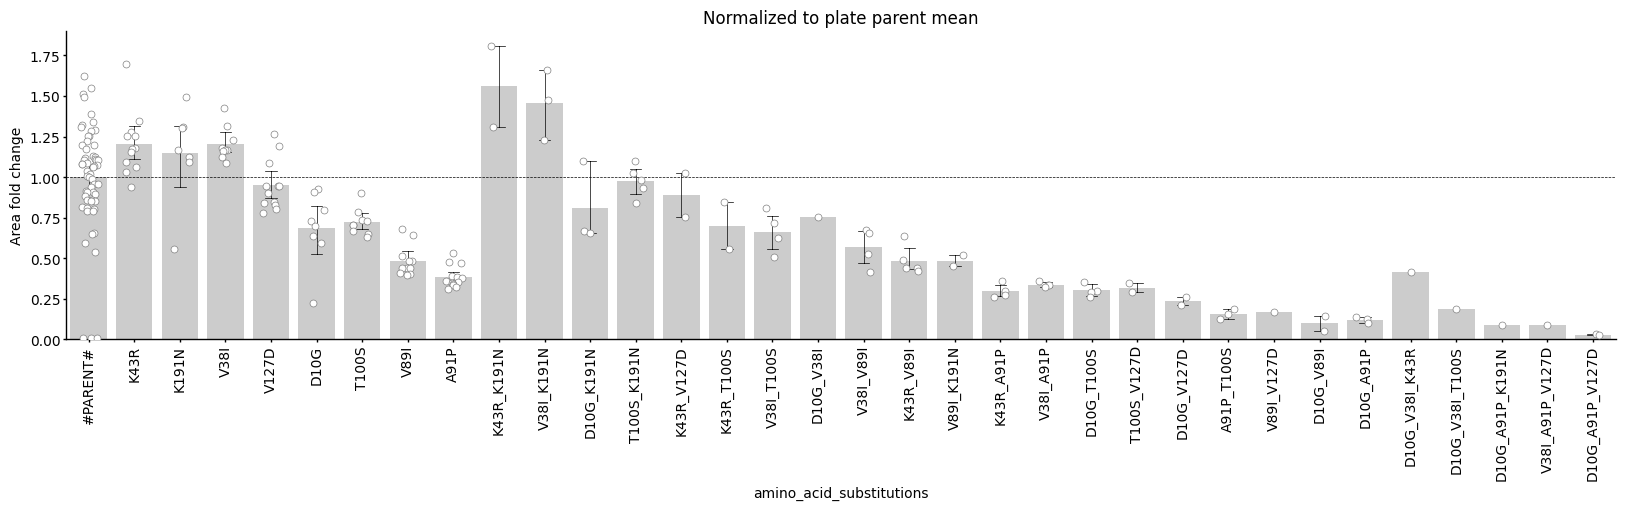

In [250]:
plt.figure(figsize=(20, 4))
plate_df = all_df.copy()# all_df[all_df['amino_acid_substitutions'] == '#PARENT#']
plate_df = plate_df.reset_index()
plate_df['num_muts'] = [len(m.split('_')) for m in plate_df['amino_acid_substitutions'].values]
plate_df = plate_df.sort_values(by=['num_muts', 'Area fold change'], ascending=[True, False])
order = list(plate_df['amino_acid_substitutions'].unique())
order = ['#PARENT#'] + [p for p in order if p not in ['#PARENT#', '#N.A.#', 'LEN', '#LOW#']]
ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
                   err_kws={"color": 'black', "linewidth": 0.5},
                     capsize=.25, palette=['#cccc'],legend=False)
ax = sns.stripplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order, ax=ax, jitter=0.2, c='white', edgecolor='grey', linewidth=0.5)
ax.axhline(y=1, c='black', linestyle='--', linewidth=0.5)
ax = clean_plt(ax)
plt.title('Normalized to plate parent mean')
plt.savefig('figs/G7_step_parent_mean_norm_all.png', 
            dpi=300, 
            bbox_inches='tight', 
            transparent=True)
plt.show()

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: UserWarning: 
The palette list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,


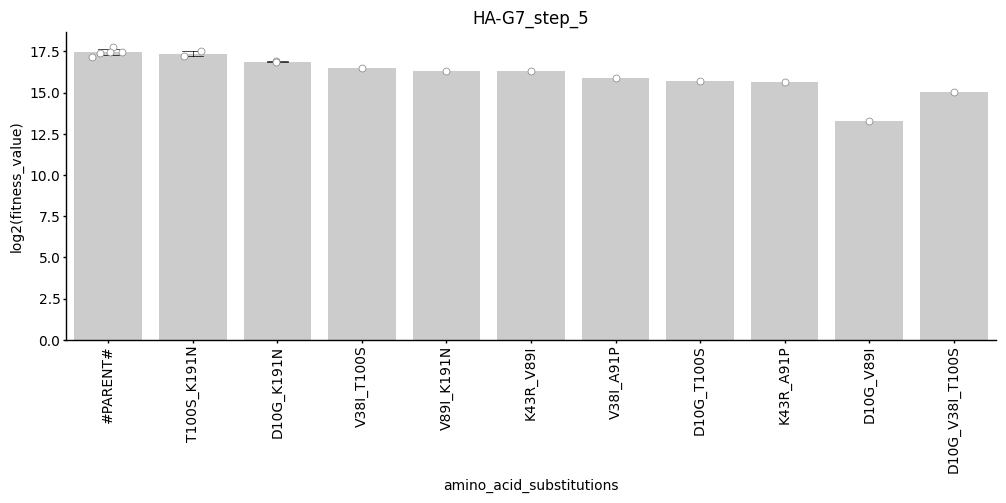

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: UserWarning: 
The palette list has fewer values (1) than needed (14) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,


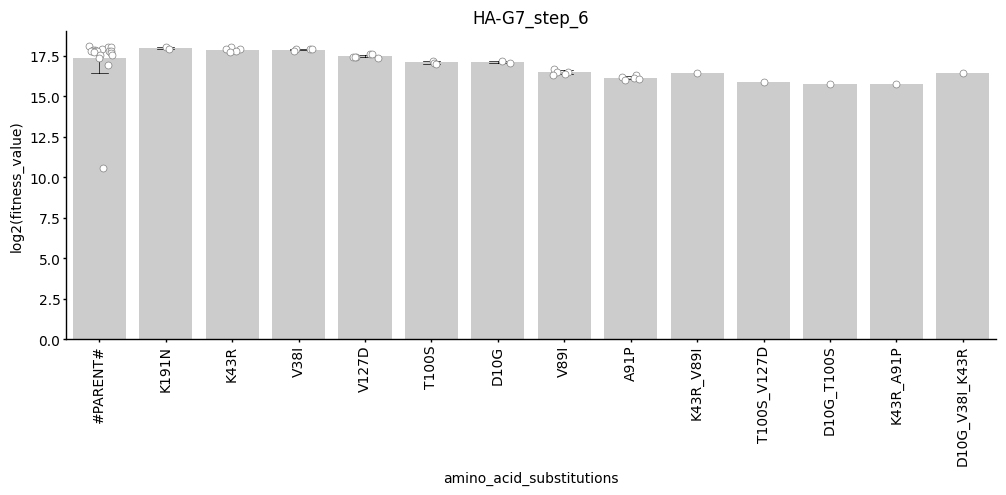

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,


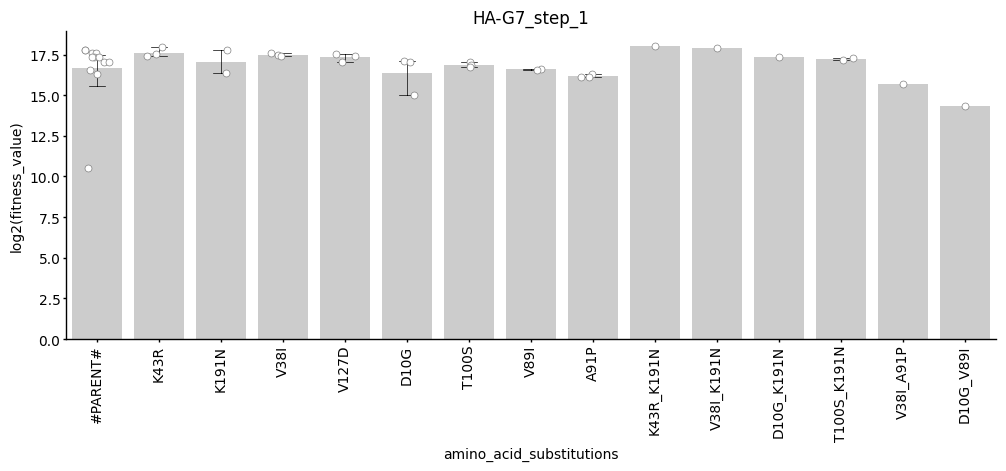

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,


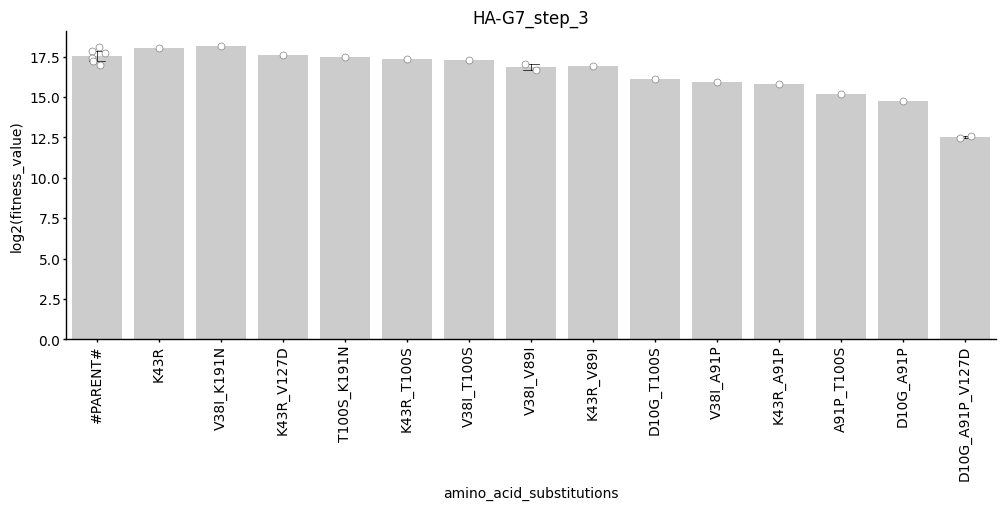

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: UserWarning: 
The palette list has fewer values (1) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,


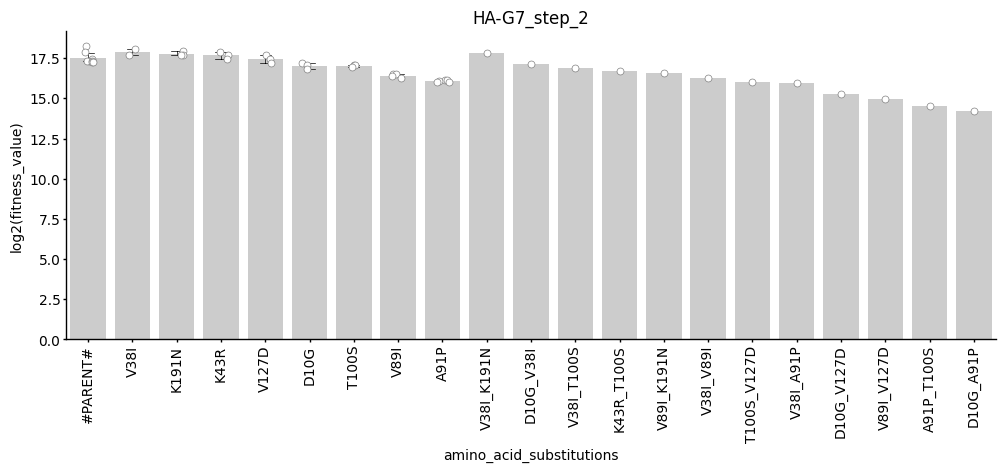

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4187470568.py:13: UserWarning: 
The palette list has fewer values (1) than needed (13) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,


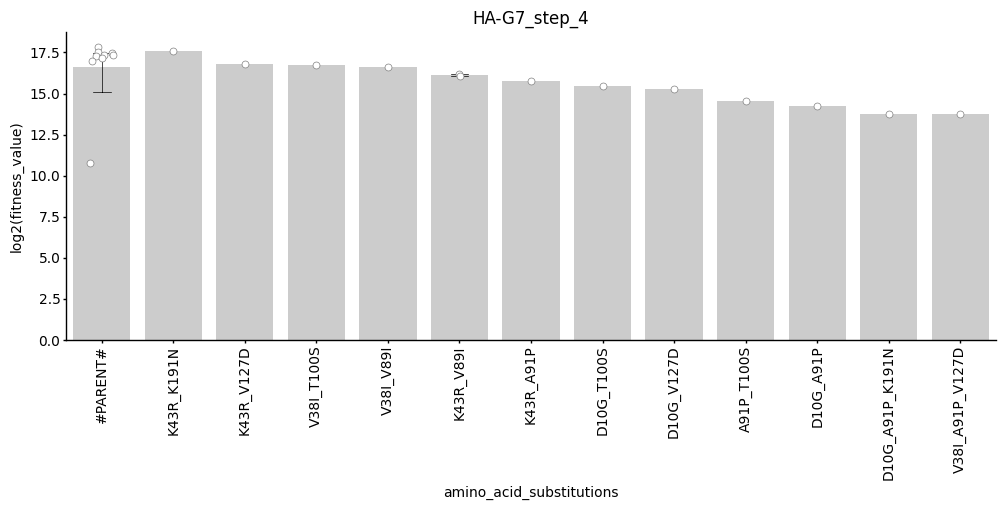

In [251]:
# For each plate do this
for plate in set(all_df['plate'].values):
    plt.figure(figsize=(12, 4))
    
    plate_df = all_df[all_df['plate'] == plate]
    plate_df = plate_df.reset_index()
    plate_df['log2(fitness_value)'] = np.log2(plate_df['fitness_value'].values + 1)
    plate_df['num_muts'] = [len(m.split('_')) for m in plate_df['amino_acid_substitutions'].values]
    plate_df = plate_df.sort_values(by=['num_muts', 'Area fold change'], ascending=[True, False])
    order = list(plate_df['amino_acid_substitutions'].unique())
    order = ['#PARENT#'] + [p for p in order if p not in ['#PARENT#', '#N.A.#', 'LEN', '#LOW#']]

    ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order,
                       err_kws={"color": 'black', "linewidth": 0.5},
                         capsize=.25, palette=['#cccc'],legend=False)
    ax = sns.stripplot(plate_df, x='amino_acid_substitutions', y='log2(fitness_value)', order=order, ax=ax, jitter=0.2, c='white', edgecolor='grey', linewidth=0.5)
    #ax.axhline(y=1, c='black', linestyle='--', linewidth=0.5)
    
    ax = clean_plt(ax)
    plt.title(plate)
    plt.savefig(f'figs/G7_step_parent_log2fitness_{plate}.png', 
            bbox_inches='tight', 
            dpi=300, 

            transparent=True)
    plt.show()

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: UserWarning: 
The palette list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,


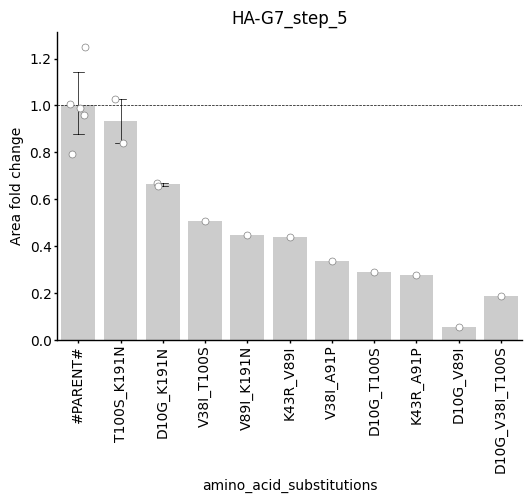

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: UserWarning: 
The palette list has fewer values (1) than needed (14) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,


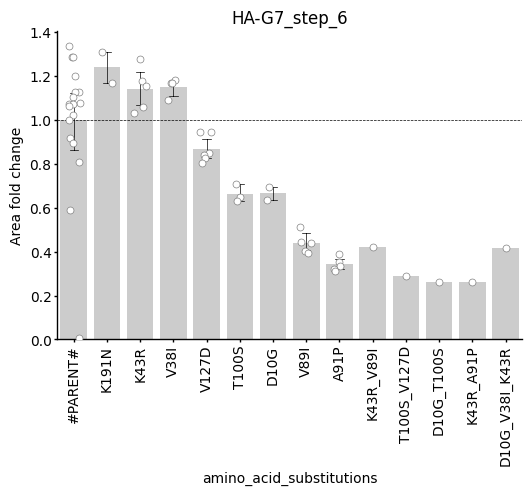

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,


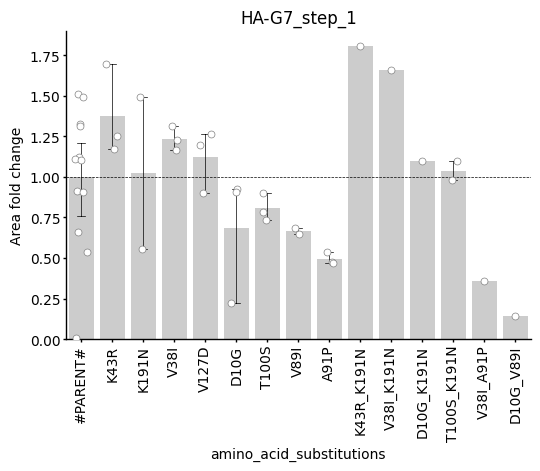

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,


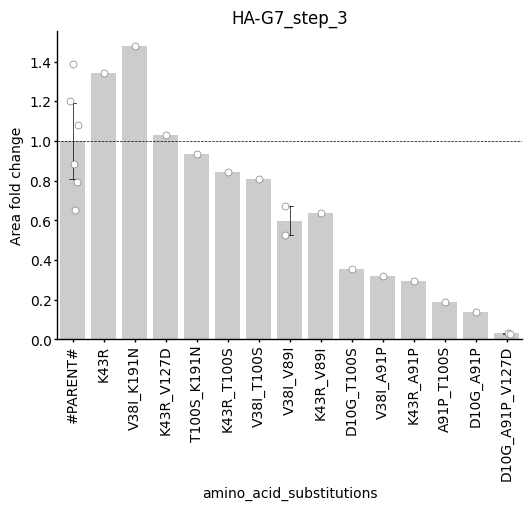

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: UserWarning: 
The palette list has fewer values (1) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,


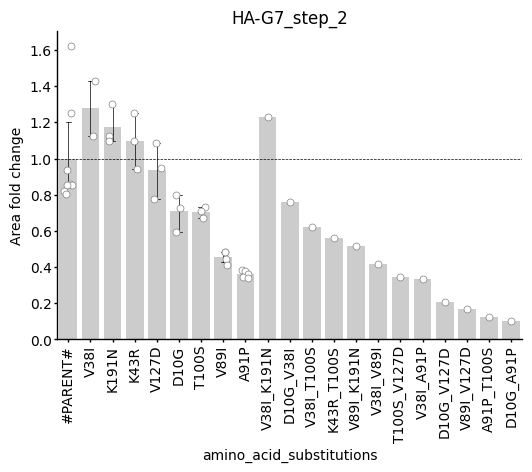

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/4193836639.py:13: UserWarning: 
The palette list has fewer values (1) than needed (13) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,


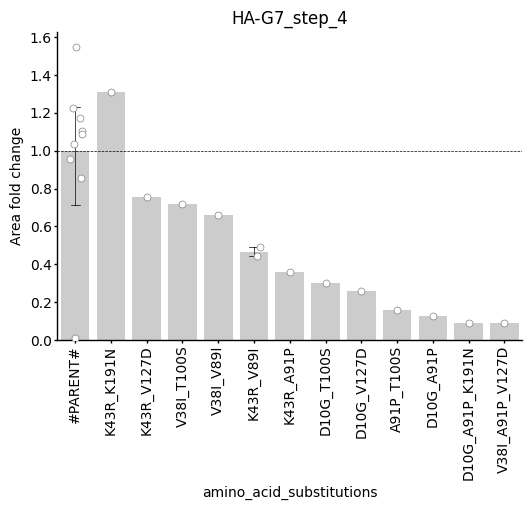

In [252]:
# For each plate do this
for plate in set(all_df['plate'].values):
    plt.figure(figsize=(6, 4))
    
    plate_df = all_df[all_df['plate'] == plate]
    plate_df = plate_df.reset_index()
    plate_df['log2(fitness_value)'] = np.log2(plate_df['fitness_value'].values + 1)
    plate_df['num_muts'] = [len(m.split('_')) for m in plate_df['amino_acid_substitutions'].values]
    plate_df = plate_df.sort_values(by=['num_muts', 'Area fold change'], ascending=[True, False])
    order = list(plate_df['amino_acid_substitutions'].unique())
    order = ['#PARENT#'] + [p for p in order if p not in ['#PARENT#', '#N.A.#', 'LEN', '#LOW#']]

    ax = sns.barplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order,
                       err_kws={"color": 'black', "linewidth": 0.5},
                         capsize=.25, palette=['#cccc'],legend=False)
    ax = sns.stripplot(plate_df, x='amino_acid_substitutions', y='Area fold change', order=order, ax=ax, jitter=0.2, c='white', edgecolor='grey', linewidth=0.5)
    ax.axhline(y=1, c='black', linestyle='--', linewidth=0.5)
    
    ax = clean_plt(ax)
    plt.title(plate)
    plt.savefig(f'figs/G7_step_parent_norm_{plate}.png', 
            bbox_inches='tight', 
                dpi=300,
            transparent=True)
    plt.show()

# Finally check if 191N, 43R or 38I were ever negative (alone)

In each generation we want to look at whether there was a time when they were negative 

Which campaigns they occured in.

active site: 91 (destroying the structure), 

In [236]:
h2noh_camp  = ['H2NOH_G6-2', 'H2NOH_G5', 'H2NOH_G6', 'H2NOH_G2', 'H2NOH_G3', 'H2NOH_G4']

df = pd.read_csv(f'{output_dir}LevSeq_CombinedDF_pdt_All.csv')
df = df[df['campaign_name'].isin(h2noh_camp)]
# Get the individuals from our substitutions 
subs = ['43R', '191N', '38I']
single_aas = [True if len(x.split('_')) == 1 else False for x in df['amino_acid_substitutions'].values]
df = df[single_aas]
df['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
#PARENT#    758
#LOW#       321
#N.A.#       87
I149L        60
LEN          49
           ... 
V89C          1
V89D          1
V116H         1
K43C          1
D10V          1
Name: count, Length: 496, dtype: int64

100S
campaign_name
H2NOH_G2      3
H2NOH_G6-2    1
Name: count, dtype: int64


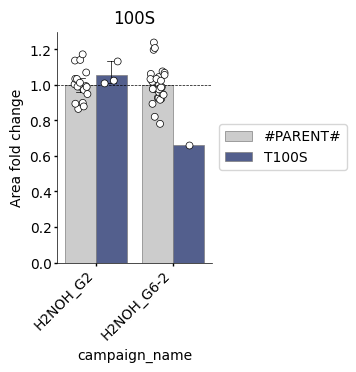

10G
campaign_name
H2NOH_G2    6
Name: count, dtype: int64


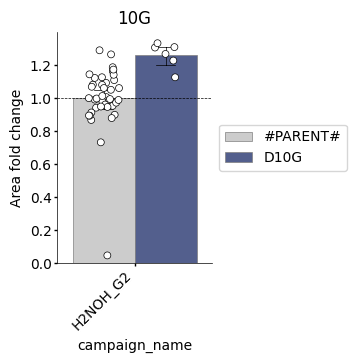

91P
campaign_name
H2NOH_G2    4
Name: count, dtype: int64


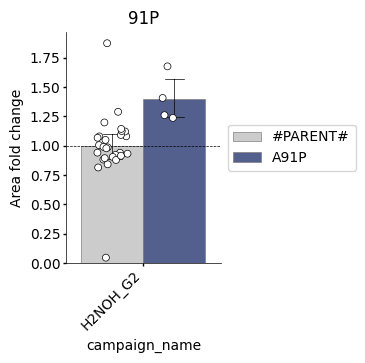

127D
campaign_name
H2NOH_G2    8
Name: count, dtype: int64


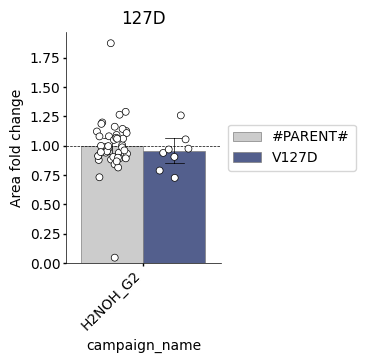

191N
campaign_name
H2NOH_G2      1
H2NOH_G6-2    1
Name: count, dtype: int64


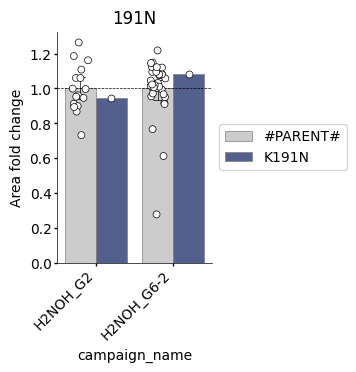

89I
campaign_name
H2NOH_G3    2
Name: count, dtype: int64


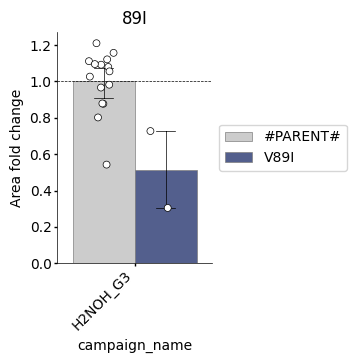

38I
campaign_name
H2NOH_G2      15
H2NOH_G3       5
H2NOH_G6-2     1
Name: count, dtype: int64


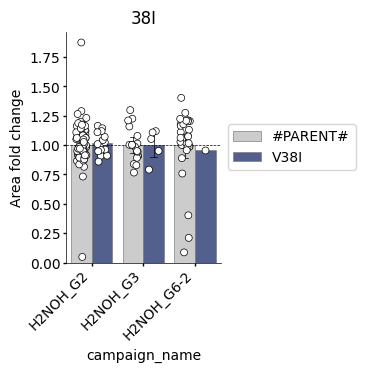

43R
campaign_name
H2NOH_G5      10
H2NOH_G6       1
H2NOH_G6-2     1
Name: count, dtype: int64


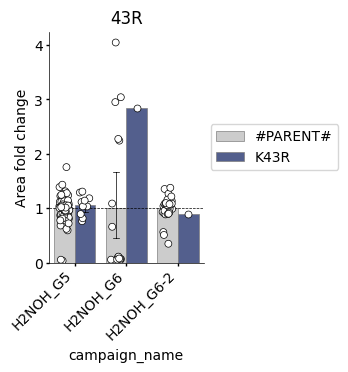

In [254]:
def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=45, ha='right')
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax
controls = ['2A',
 '29T',
 '59M',
 '61R',
 '62Y',
 '86F',
 '116R',
 '134A',
 '149L',
 '167V',
 '174L']

# Now filter 
df['single_aa'] =  [a[1:] for a in df['amino_acid_substitutions'].values]
filtered_df = pd.concat([df[df['single_aa'].isin(singles)], df[df['single_aa'].isin(controls)]])
for aa in singles:
    aa_df = filtered_df[filtered_df['single_aa'] == aa]
    print(aa)
    print(aa_df['campaign_name'].value_counts())
    # Parents
    parents = df[df['plate'].isin(set(aa_df['plate'].values))]
    parents = parents[parents['amino_acid_substitutions'] == '#PARENT#']
    bar_count = len(aa_df['campaign_name'].unique())
    aa_df = pd.concat([parents, aa_df])
    plt.figure(figsize=(max(2, bar_count * 0.4), 3))  # Adjust 0.4 as needed
    ax = sns.barplot(aa_df, x='campaign_name', y='Area fold change', err_kws={"color": 'black', "linewidth": 0.5},
                     capsize=.25,
                     linewidth=0.5, edgecolor=".5", hue='amino_acid_substitutions', palette=['#cccc', '#495a97'])
    ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = clean_plt(ax)
    plt.axhline(y=1, linestyle='--', linewidth=0.5, color='black')

    plt.title(aa)
    plt.savefig(f'figs/{aa}_single_mutant.png', dpi=300, bbox_inches='tight')
    plt.show()
    # For each we want to plot a bar chart with down the bottom 

100S
campaign_name
H2NOH_G2      3
H2NOH_G6-2    1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:47: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)


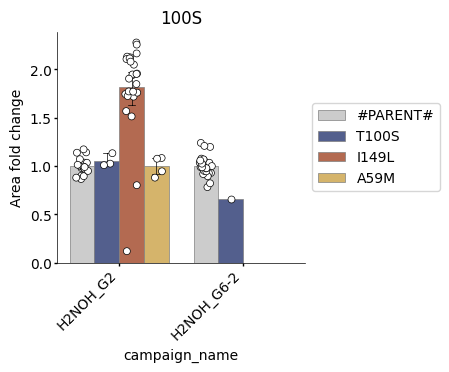

10G
campaign_name
H2NOH_G2    6
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:47: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)


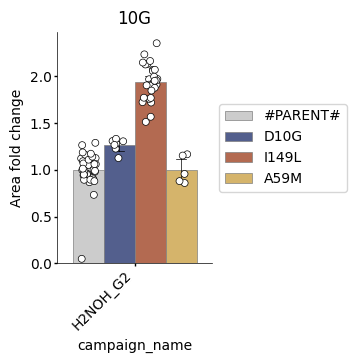

91P
campaign_name
H2NOH_G2    4
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:47: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)


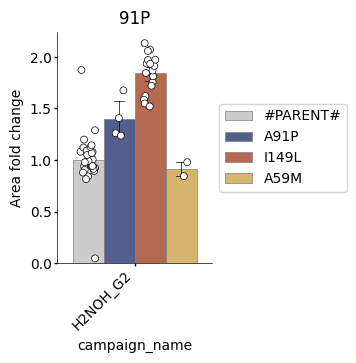

127D
campaign_name
H2NOH_G2    8
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:47: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)


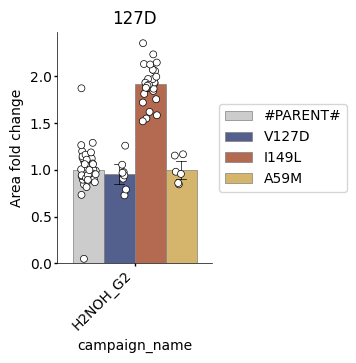

191N
campaign_name
H2NOH_G2      1
H2NOH_G6-2    1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:47: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)


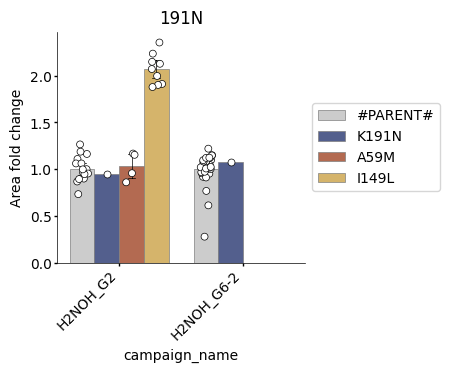

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:44: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(aa_df, x='campaign_name', y='Area fold change', err_kws={"color": 'black', "linewidth": 0.5},


89I
campaign_name
H2NOH_G3    2
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:47: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)


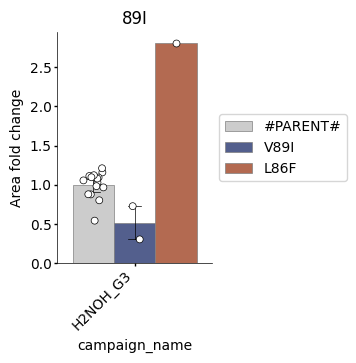

38I
campaign_name
H2NOH_G2      15
H2NOH_G3       5
H2NOH_G6-2     1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:47: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)


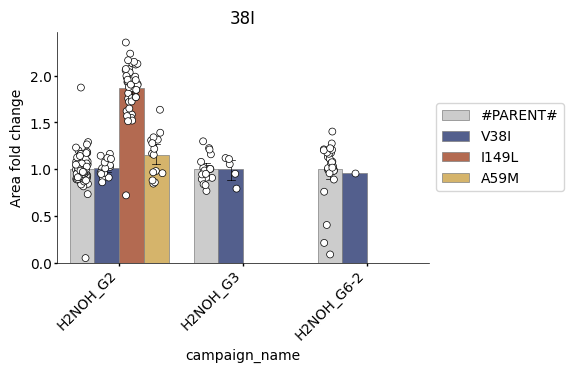

43R
campaign_name
H2NOH_G5      10
H2NOH_G6       1
H2NOH_G6-2     1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/3351138592.py:47: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)


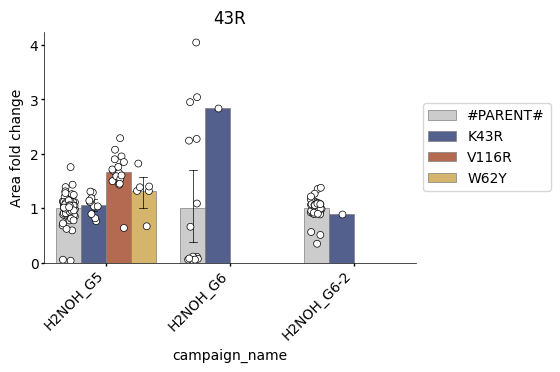

In [202]:
def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=45, ha='right')
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax
controls = ['2A',
 '29T',
 '59M',
 '61R',
 '62Y',
 '86F',
 '116R',
 '134A',
 '149L',
 '167V',
 '174L']

# Now filter 
df['single_aa'] =  [a[1:] for a in df['amino_acid_substitutions'].values]
filtered_df = df[df['single_aa'].isin(singles)] #, df[df['single_aa'].isin(controls)]])

control_df = df[df['single_aa'].isin(controls)]
for aa in singles:
    aa_df = filtered_df[filtered_df['single_aa'] == aa]
    #aa_df = pd.concat([aa_df, filtered_df[filtered_df['single_aa'].isin(controls)]])

    print(aa)
    print(aa_df['campaign_name'].value_counts())
    # Parents
    parents = df[df['plate'].isin(set(aa_df['plate'].values))]
    parents = parents[parents['amino_acid_substitutions'] == '#PARENT#']
    control_aa = control_df[control_df['plate'].isin(set(aa_df['plate'].values))]

    aa_df = pd.concat([parents, aa_df, control_aa])
    bar_count = len(aa_df['campaign_name'].unique())*len(aa_df['amino_acid_substitutions'].unique())

    plt.figure(figsize=(max(2, bar_count * 0.4), 3))  # Adjust 0.4 as needed
    ax = sns.barplot(aa_df, x='campaign_name', y='Area fold change', err_kws={"color": 'black', "linewidth": 0.5},
                     capsize=.25,
                     linewidth=0.5, edgecolor=".5", hue='amino_acid_substitutions', palette=['#cccc', '#495a97', '#c36241', '#e7bb59'])
    ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = clean_plt(ax)
    plt.title(aa)
    plt.savefig(f'figs/{aa}_single_mutant_with_control_singleAA.svg')
    plt.show()
    # For each we want to plot a bar chart with down the bottom 

In [245]:
h2noh_camp  = ['H2NOH_G6-2', 'H2NOH_G5', 'H2NOH_G6', 'H2NOH_G2', 'H2NOH_G3', 'H2NOH_G4']

df = pd.read_csv(f'{output_dir}LevSeq_CombinedDF_pdt_All.csv')
df = df[df['campaign_name'].isin(h2noh_camp)]
rows = []
for pos, value in df[['amino_acid_substitutions', 'Area fold change']].values:
    positions = pos.split('_')
    for i in positions:
        try:
            rows.append([pos, i[1:], int(i[1:-1]), i[-1], float(value), len(pos.split('_'))])
        except:
            rows.append([pos, pos, pos, pos, float(value), len(pos.split('_'))])

vis_df = pd.DataFrame(rows, columns=['amino_acid_substitutions', 'change', 'position', 'aa', 'value', '# substiutions'])
vis_df

,amino_acid_substitutions,change,position,aa,value,# substiutions
0,#PARENT#,#PARENT#,#PARENT#,#PARENT#,0.652163,1
1,P81M,81M,81,M,0.545332,1
2,P81V_R132H,81V,81,V,0.470893,2
3,P81V_R132H,132H,132,H,0.470893,2
4,P81Y,81Y,81,Y,0.474632,1
...,...,...,...,...,...,...
4364,#PARENT#,#PARENT#,#PARENT#,#PARENT#,1.056665,1
4365,S65P_W185R,65P,65,P,0.177677,2
4366,S65P_W185R,185R,185,R,0.177677,2
4367,#PARENT#,#PARENT#,#PARENT#,#PARENT#,0.929521,1


In [246]:
aa_df


,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD,single_aa
2464,18,HA-K43X,#PARENT#,#PARENT#,A2,0.000000,205.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,3.0,D3F-A2,...,JR-20250215-HA-K43X_achiral_18.csv,20250215_SSM-H2NOH,8.673795e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-1.095034,0.849154,1.021464e+06,140711.863893,PARENT#
2471,18,HA-K43X,#PARENT#,#PARENT#,B3,0.000000,137.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,10.0,D3F-B3,...,JR-20250215-HA-K43X_achiral_18.csv,20250215_SSM-H2NOH,9.928118e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-0.203621,0.971950,1.021464e+06,140711.863893,PARENT#
2479,18,HA-K43X,#PARENT#,#PARENT#,C4,0.000000,32.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,18.0,D3F-C4,...,JR-20250215-HA-K43X_achiral_18.csv,20250215_SSM-H2NOH,9.750999e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-0.329495,0.954610,1.021464e+06,140711.863893,PARENT#
2501,18,HA-K43X,#PARENT#,#PARENT#,F11,0.000000,138.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,40.0,D3F-F11,...,JR-20250215-HA-K43X_achiral_18.csv,20250215_SSM-H2NOH,1.250564e+06,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,1.628150,1.224286,1.021464e+06,140711.863893,PARENT#
2752,37,HA-StEP1,#PARENT#,#PARENT#,A2,0.000000,170.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,3.0,D3F-A2,...,JR-20250227-step1_37.csv,20250227_StEP-H2NOH,1.337862e+06,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,0.820837,1.139154,1.174435e+06,199098.198828,PARENT#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,38,HA-StEP2,A127C_A128G_G129T,K43R,D12,0.879252,196.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKRAAD...,49.0,D3B-D12,...,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,1.561071e+06,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,0.397932,1.139178,1.370348e+06,479284.919555,43R
2903,38,HA-StEP2,A127C_A128G_G129T,K43R,E9,0.747475,99.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKRAAD...,58.0,D3B-E9,...,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,1.115556e+06,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-0.531609,0.814068,1.370348e+06,479284.919555,43R
3900,40,HA-K43X,A127C_A128G_G129T,K43R,F8,0.617816,116.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKRAAD...,69.0,D3F-F8,...,250319-JR-HA-K43X_40.csv,20250319_SSM-H2NOH,8.404862e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,1.412054,2.851230,2.947803e+04,38646.252733,43R
4299,10,H2NO-G8-300-1,A128G,K43R,D11,0.947368,133.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKRAAD...,48.0,D4B-D11,...,H2NO-G8-300-1_10.csv,20241021-JR-epPCR-H2NOH,1.158522e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-0.842406,0.891611,1.299358e+05,16718.310671,43R


100S
campaign_name
H2NOH_G2      17
H2NOH_G6-2     1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: UserWarning: 
The palette list has fewer values (2) 

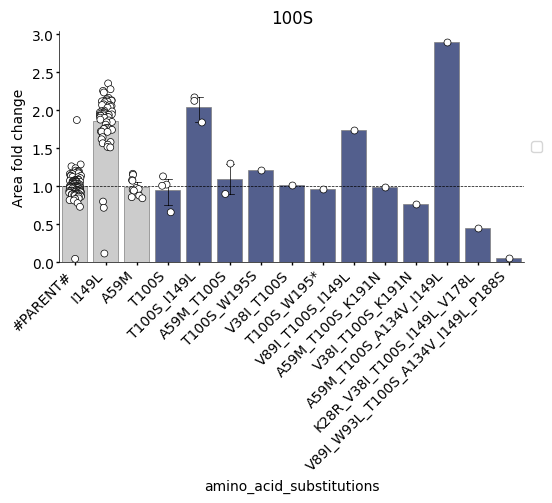

10G
campaign_name
H2NOH_G2      30
H2NOH_G6-2     1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: UserWarning: 
The palette list has fewer values (2) 

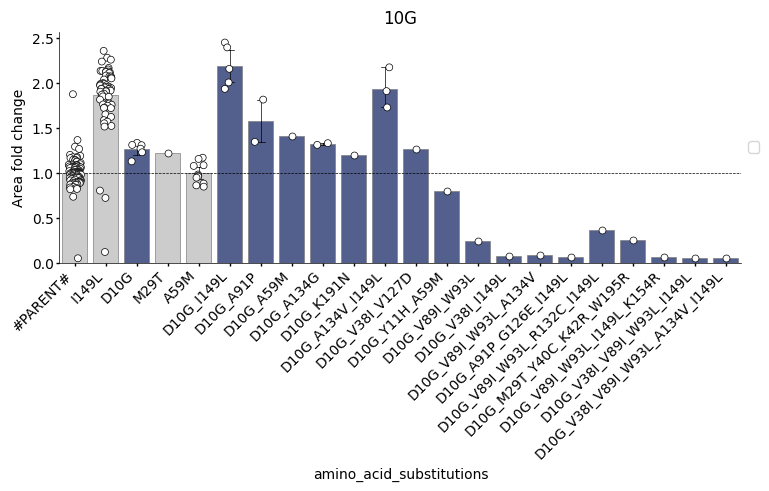

91P
campaign_name
H2NOH_G2    25
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: UserWarning: 
The palette list has fewer values (2) 

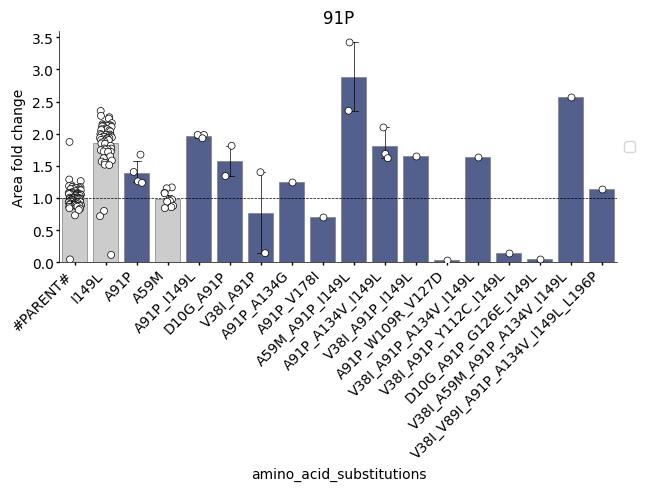

127D
campaign_name
H2NOH_G2    27
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: UserWarning: 
The palette list has fewer values (2) 

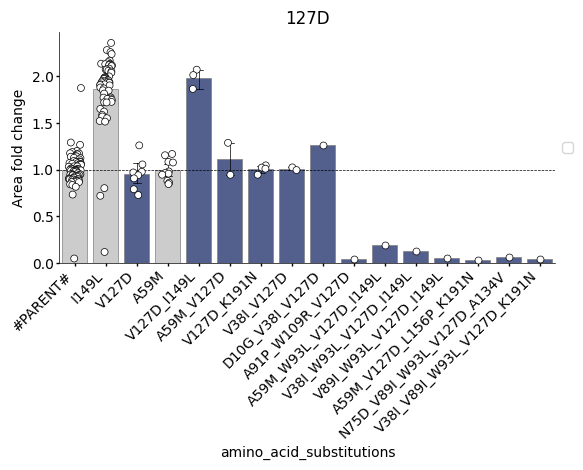

191N
campaign_name
H2NOH_G2      32
H2NOH_G6-2     1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: UserWarning: 
The palette list has fewer values (2) 

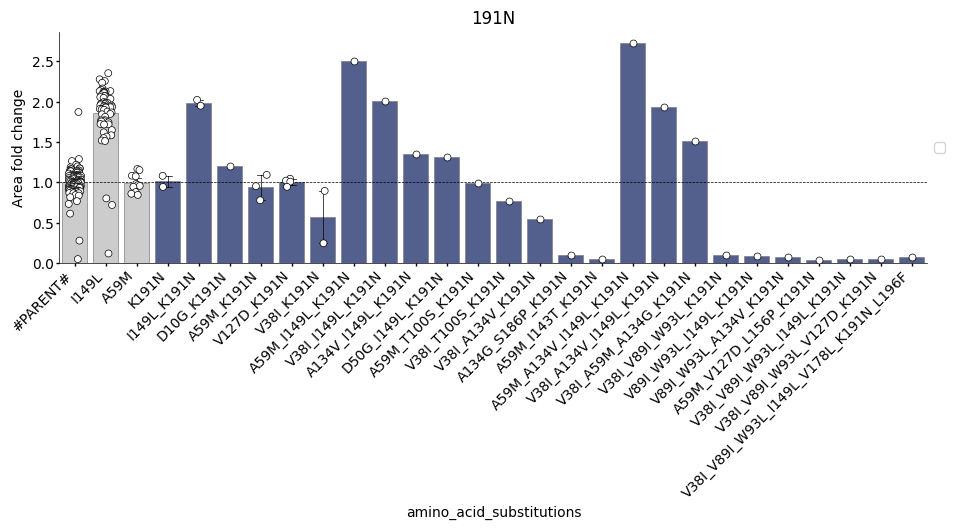

89I
campaign_name
H2NOH_G2    101
H2NOH_G5      2
H2NOH_G3      2
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: UserWarning: 
The palette list has fewer values (2) 

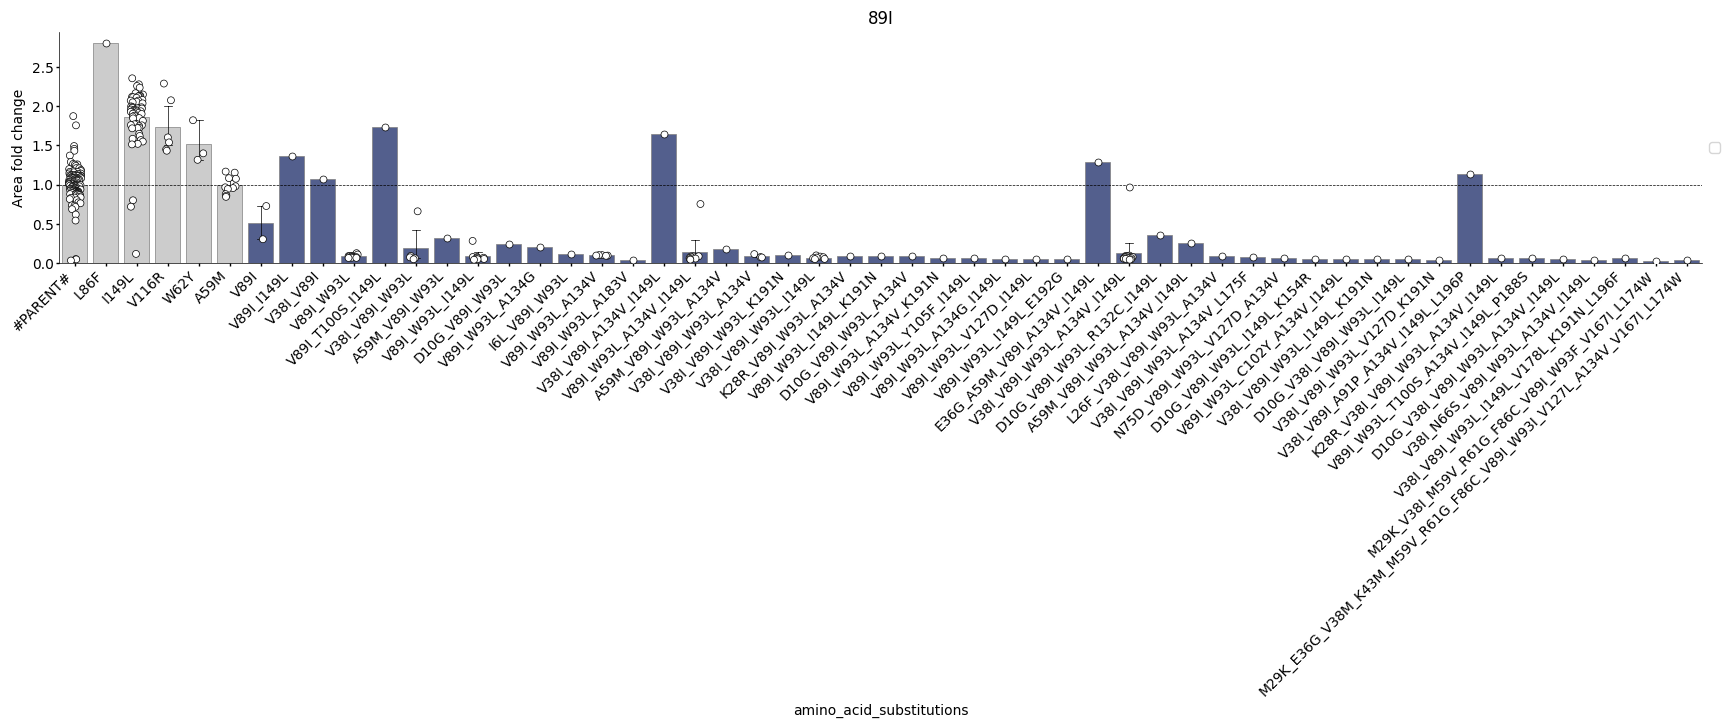

38I
campaign_name
H2NOH_G2      106
H2NOH_G3        5
H2NOH_G5        1
H2NOH_G6-2      1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: UserWarning: 
The palette list has fewer values (2) 

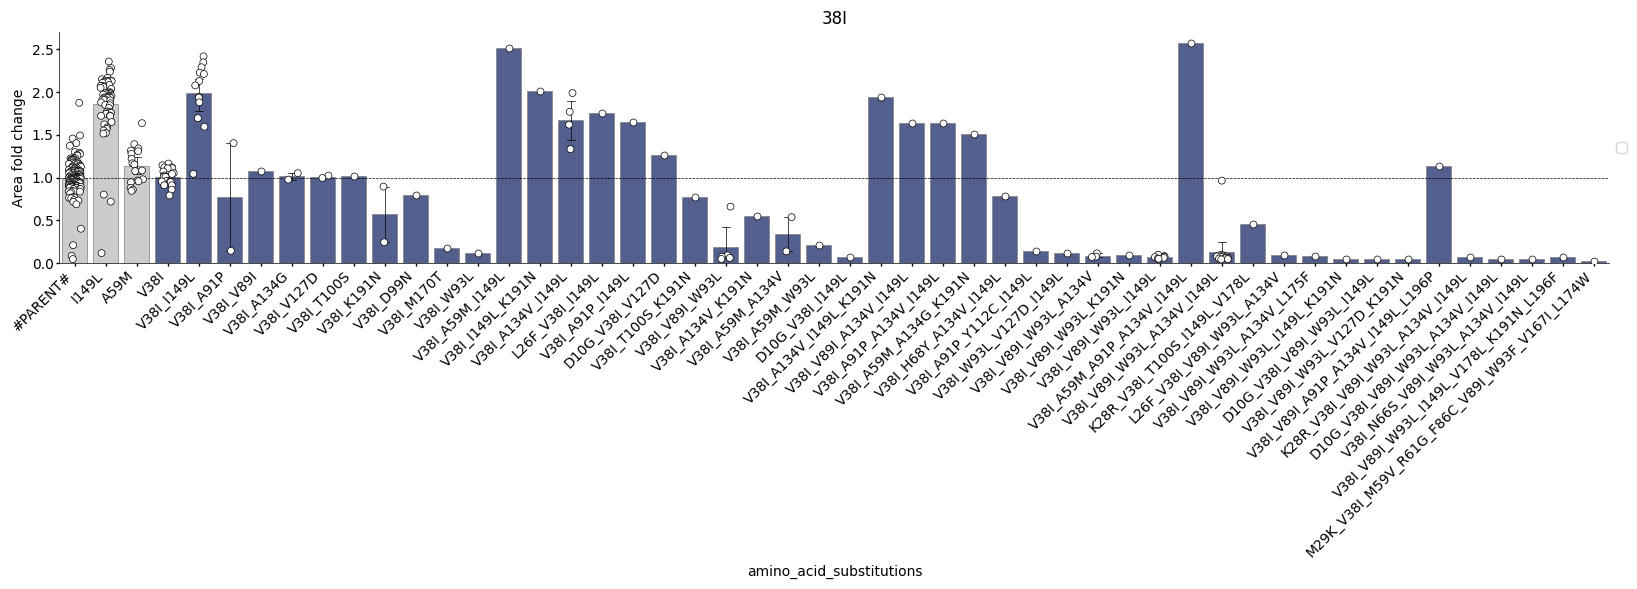

43R
campaign_name
H2NOH_G5      19
H2NOH_G6       1
H2NOH_G6-2     1
Name: count, dtype: int64


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_66424/511170286.py:24: UserWarning: 
The palette list has fewer values (2) 

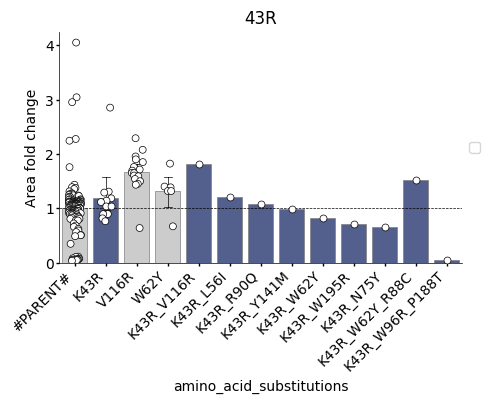

In [255]:
for aa in singles:
    amino_acid_substitutions = set(vis_df[vis_df['change'] == aa]['amino_acid_substitutions'].values)

    aa_df = df[df['amino_acid_substitutions'].isin(amino_acid_substitutions)]
    print(aa)
    print(aa_df['campaign_name'].value_counts())
    # Parents
    parents = df[df['plate'].isin(set(aa_df['plate'].values))]
    control_aa = control_df[control_df['plate'].isin(set(aa_df['plate'].values))]

    parents = parents[parents['amino_acid_substitutions'] == '#PARENT#']
    aa_df = pd.concat([parents, aa_df, control_aa])
    bar_count = len(aa_df['amino_acid_substitutions'].unique())
    plt.figure(figsize=(max(4, bar_count * 0.4), 3))  # Adjust 0.4 as needed

    aa_df['num_muts'] = [len(m.split('_')) for m in aa_df['amino_acid_substitutions'].values]
    aa_df = aa_df.sort_values(by=['num_muts', 'Area fold change'], ascending=[True, False])
    order = list(aa_df['amino_acid_substitutions'].unique())
    order = ['#PARENT#'] + [p for p in order if p not in ['#PARENT#', '#N.A.#', 'LEN', '#LOW#']]
    palette = ['#ccc' if not aa in a else '#495a97' for a in order]
    ax = sns.barplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, err_kws={"color": 'black', "linewidth": 0.5},
                     capsize=.25, palette=palette, legend=False,
                     linewidth=0.5, edgecolor=".5")
    ax = sns.stripplot(aa_df, x='amino_acid_substitutions', y='Area fold change', order=order, palette=['white', 'white'], legend=False, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axhline(y=1, linestyle='--', linewidth=0.5, color='black')
    ax = clean_plt(ax)
    plt.title(aa)
    plt.savefig(f'figs/{aa}_all_mutant.png', dpi=300, bbox_inches='tight')
    plt.show()
    # For each we want to plot a bar chart with down the bottom 

In [248]:
aa_df

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD
2947,6,StEP1,G175A_C176T_A298T,A59M_T100S,A7,0.821705,43.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,8.0,D3F-A7,...,6,StEP1_6.csv,20240504-JR-StEP-H2NOH,322603.2295,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,-0.357402,0.900487,358254.103408,99750.003858
2961,6,StEP1,G112A_A298T_G573T,V38I_T100S_K191N,B10,0.894253,145.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,23.0,D3F-B10,...,6,StEP1_6.csv,20240504-JR-StEP-H2NOH,274807.6730,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,-0.836556,0.767075,358254.103408,99750.003858
3025,6,StEP1,G112A_A298T,V38I_T100S,H6,0.899038,104.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,91.0,D3F-H6,...,6,StEP1_6.csv,20240504-JR-StEP-H2NOH,364962.4180,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,0.067251,1.018725,358254.103408,99750.003858
3041,7,StEP2,T39A_A83G_G112A_A298T_A445C_C447G_G532C,K28R_V38I_T100S_I149L_V178L,B1,0.740260,11.0,MTPSDIPGYDYGRVEKSPITDLEFDLLRKTVMLGEEDIMYLKKAAD...,14.0,D3B-B1,...,7,StEP2_7.csv,20240504-JR-StEP-H2NOH,143323.0989,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,-7.371935,0.452409,316799.590900,23532.016567
3073,7,StEP2,T180A_A298T,T100S,D9,0.800000,30.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,46.0,D3B-D9,...,7,StEP2_7.csv,20240504-JR-StEP-H2NOH,324342.3255,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,0.320531,1.023809,316799.590900,23532.016567
3078,7,StEP2,T39A_G84A_G175A_C176T_A298T_G393A_C401T_A445C_...,A59M_T100S_A134V_I149L,E2,0.845238,28.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,51.0,D3B-E2,...,7,StEP2_7.csv,20240504-JR-StEP-H2NOH,916889.9621,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,25.501018,2.894227,316799.590900,23532.016567
3106,7,StEP2,G175A_C176T_A298T_G573T,A59M_T100S_K191N,G10,0.852273,22.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,83.0,D3B-G10,...,7,StEP2_7.csv,20240504-JR-StEP-H2NOH,314958.2718,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,-0.078247,0.994188,316799.590900,23532.016567
3198,8,StEP3,T39A_A298T_G584C_G585C,T100S_W195S,G11,0.878713,101.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,84.0,D4F-G11,...,8,StEP3_8.csv,20240504-JR-StEP-H2NOH,402424.8946,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,0.827195,1.221442,329466.983807,88199.160911
3215,9,StEP4,G175A_C176T_A298T,A59M_T100S,A5,0.913420,154.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,6.0,D4B-A5,...,9,StEP4_9.csv,20240504-JR-StEP-H2NOH,434188.4376,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,2.984845,1.300029,333983.617873,33571.202014
3281,9,StEP4,G265A_T277C_G278T_G279T_A298T_G393A_C401T_A445...,V89I_W93L_T100S_A134V_I149L_P188S,G4,0.882432,74.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,77.0,D4B-G4,...,9,StEP4_9.csv,20240504-JR-StEP-H2NOH,20672.2730,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,-9.332741,0.061896,333983.617873,33571.202014


100S
campaign_name
H2NOH_G2      3
H2NOH_G6-2    1
Name: count, dtype: int64


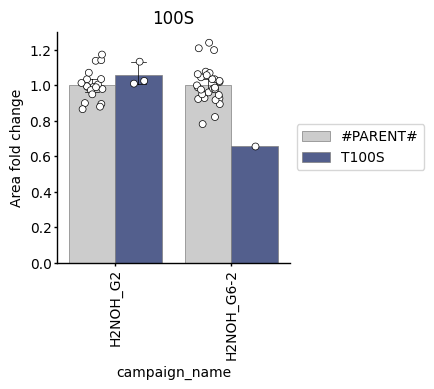

10G
campaign_name
H2NOH_G2    6
Name: count, dtype: int64


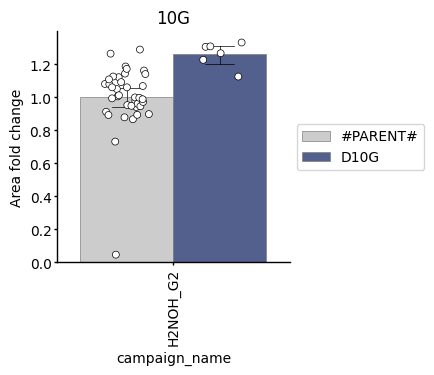

91P
campaign_name
H2NOH_G2    4
Name: count, dtype: int64


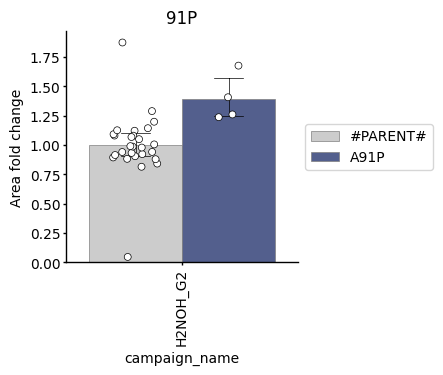

127D
campaign_name
H2NOH_G2    8
Name: count, dtype: int64


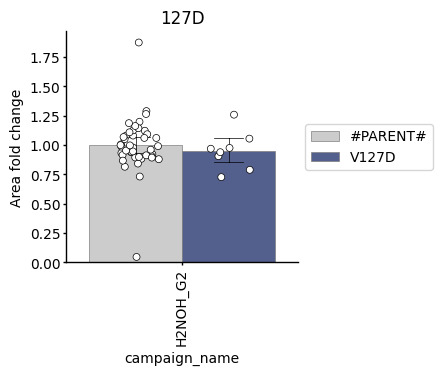

191N
campaign_name
H2NOH_G2      1
H2NOH_G6-2    1
Name: count, dtype: int64


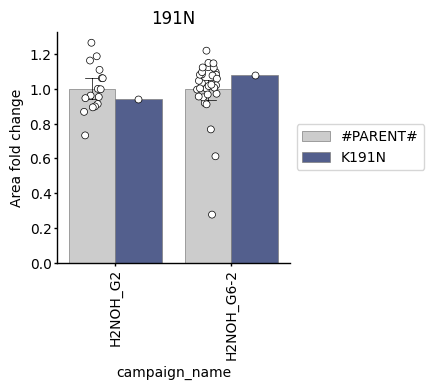

89I
campaign_name
H2NOH_G3    2
Name: count, dtype: int64


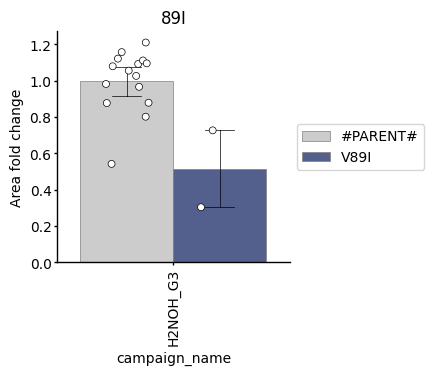

38I
campaign_name
H2NOH_G2      15
H2NOH_G3       5
H2NOH_G6-2     1
Name: count, dtype: int64


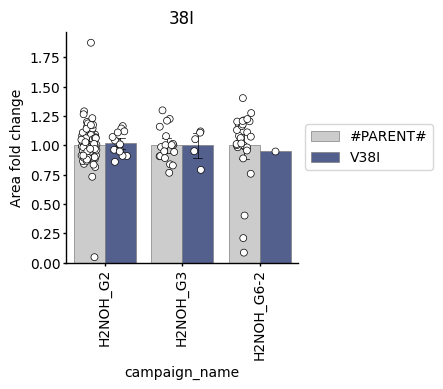

43R
campaign_name
H2NOH_G5      10
H2NOH_G6       1
H2NOH_G6-2     1
Name: count, dtype: int64


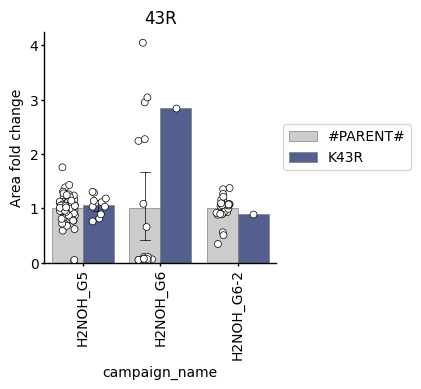

In [244]:
def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=90)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax


# Now filter 
df['single_aa'] =  [a[1:] for a in df['amino_acid_substitutions'].values]
filtered_df = df[df['single_aa'].isin(singles)]
for aa in singles:
    aa_df = filtered_df[filtered_df['single_aa'] == aa]
    print(aa)
    print(aa_df['campaign_name'].value_counts())
    # Parents
    parents = df[df['plate'].isin(set(aa_df['plate'].values))]
    parents = parents[parents['amino_acid_substitutions'] == '#PARENT#']
    aa_df = pd.concat([parents, aa_df])
    plt.figure(figsize=(3, 3))
    ax = sns.barplot(aa_df, x='campaign_name', y='Area fold change', err_kws={"color": 'black', "linewidth": 0.5},
                     capsize=.25,
                     linewidth=0.5, edgecolor=".5", hue='amino_acid_substitutions', palette=['#cccc', '#495a97'])
    ax = sns.stripplot(aa_df, x='campaign_name', y='Area fold change', hue='amino_acid_substitutions', palette=['white', 'white'], legend=False, dodge=True, ax=ax, jitter=0.2, c='white', edgecolor='black', linewidth=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = clean_plt(ax)
    plt.title(aa)
    plt.savefig(f'figs/{aa}_single_mutant.svg')
    plt.show()
    # For each we want to plot a bar chart with down the bottom 

In [97]:
aa_df

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD,# substitutions,single_aa
